# Rhandomyosarcoma analysis with Guenther Richter, Bernhard Haller, Marco Wachtel et al. (EPICYCLE/DECIDE consortium)

## 03/22/2024

## Marvin Jens 

`marvin.jens@charite.de`, `marvin-jens@gmx.de`

## Abstract

A small number of alveolar RMS (aRMS) samples were studied in multiple centers in parallel to assess reproducibility and test new treatment options. Measurements included viability and apoptosis markers in culture under treatments with CDKI-37, JQ1, combination of the two former, and Vincristine (base-line) as well as `Vehicle` negative controls. Nine of the cultured samples were also subjected to RNA-Seq (control conditions only) and nine others (of which seven overlap with the RNA-seq panel) were also subjected to DNA methylation measurements by microarrays.

My questions were:

  * How can the similarities and differences of the samples be characterized on a molecular level?
  * Which genes (or pathways) are associated with the observed viabilties and tumor doubling times?
  * How similar are the samples to primary tumors from an independently produced dataset?
  * Can we identify factors that correlate with treatment results in the RNA-seq data or methylation data?

In [51]:
import os
os.getcwd()

'/data/marjens/Downloads/epicycle_rnaseq/notebooks'

In [52]:
import matplotlib as mpl
#mpl.rcParams['figure.dpi'] = 150
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
import scanpy as sc
# from itables import init_notebook_mode
# init_notebook_mode(all_interactive=True)


In [53]:
# import sys
# sys.path.append('/home/marjens/cubi_home/work/git/mtk')
# import mtk

In [54]:
# from pydeseq2.dds import DeseqDataSet
# from pydeseq2.default_inference import DefaultInference
# from pydeseq2.ds import DeseqStats
# from pydeseq2.utils import load_example_data

# Loading samples and combining into one table


In [55]:
df_ensg = pd.read_csv("../resources/gene_names.txt.gz", sep='\t')
df_ensg['id'] = df_ensg['gene_id'].apply(lambda x : x.split('.')[0])
df_ensg = df_ensg.set_index('id')
ensg_lkup = df_ensg.to_dict()['gene_name']

In [56]:
exonic_length = {}

def load_tables(col='TPM'):
    # load all TPM values into one big matrix
    from glob import glob

    # TODO: handle rep1 and rep2 properly
    df = pd.DataFrame()
    for fname in sorted(glob("../data/featurecounts/*.fpkm_tpm.featureCounts.tsv.gz")):
        dfs = pd.read_csv(fname, sep='\t', low_memory=False).set_index('gene_id')
        # print(dfs)
        sample = os.path.basename(fname).split('_')[0]
        df[sample] = dfs[col]
        exonic_length.update(dfs['exonic_length'].to_dict())
        #exonic_length.append(dfs['exonic_length'])

    ov = pd.read_csv('../data/Sample_Overview-OE0561_RMS_Epicycle_2023-08-31.csv')
    id_lkup = {}
    for row in ov.itertuples():
        id = row[1].split("Epicycle_")[1]
        sample = row[2]
        rep = sample.split('-')[1]
        id_lkup[sample] = f"{id}.{rep}"

    df = df.rename(columns=id_lkup)
    df['gene'] = [ensg_lkup.get(x.split('.')[0], x.split('.')[0]) for x in df.index]

    return df

tpm = load_tables(col='TPM')
counts = load_tables(col='num_reads')




In [57]:
dfel = pd.DataFrame(dict(length = exonic_length))
dfel['gene'] = [ensg_lkup.get(x.split('.')[0], x.split('.')[0]) for x in dfel.index]
dfel.set_index('gene').to_csv("../resources/exonic_length.csv.gz", sep='\t')
#length_lkup


In [58]:
tpm = tpm.reset_index(drop=False).set_index('gene')
tpm.to_csv('../data/RMS_TPMs.csv.gz', sep='\t')

counts = counts.set_index('gene')
counts.to_csv('../data/RMS_read_counts.csv.gz', sep='\t')



In [59]:
# After aggregating the raw files we can start here
tpm = pd.read_csv("../data/RMS_TPMs.csv.gz", sep='\t').set_index('gene')
counts = pd.read_csv("../data/RMS_read_counts.csv.gz", sep='\t').set_index('gene')
dfel = pd.read_csv("../resources/exonic_length.csv.gz", sep='\t').set_index('gene')

In [60]:
tpm

,gene_id,IC35.r1,IC35.r2,X16.r1,X16.r2,IC104.r1,IC104.r2,BE14.r1,BE14.r2,R410.r1,...,IC29.r1,IC29.r2,BE13.r1,BE13.r2,X1.r1,X1.r2,ZH3.r1,ZH3.r2,Be10.r1,Be10.r2
gene,,,,,,,,,,,,,,,,,,,,,
DDX11L1,ENSG00000223972.4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.117910,0.000000,...,0.000000,0.000000,0.000000,0.416130,0.146757,0.000000,0.000000,0.000000,0.000000,0.000000
WASH7P,ENSG00000227232.4,13.363119,9.202646,9.039572,11.089001,9.560844,8.300247,13.424684,13.783313,6.102230,...,14.631839,13.661090,13.737983,17.742296,12.804442,10.554633,15.825958,17.847681,10.857767,10.444332
MIR1302-2HG,ENSG00000243485.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
FAM138A,ENSG00000237613.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
OR4G4P,ENSG00000268020.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MT-ND6,ENSG00000198695.2,12168.189648,10616.183909,15153.587129,13165.991115,17901.755983,25507.289497,16315.796604,15530.277981,6764.219006,...,14577.167111,15113.119132,13074.837898,13565.951224,16262.409031,16826.076122,12876.302198,13968.384077,12724.697471,11665.867935
MT-TE,ENSG00000210194.1,461.695761,532.972493,649.142860,535.169960,758.182632,1915.437653,1143.802245,1191.283881,168.782046,...,650.099863,540.720825,649.200562,515.389957,2207.298854,1728.938416,568.632608,554.321494,1151.911724,624.579694
MT-CYB,ENSG00000198727.2,14801.860888,14918.733863,17768.052171,16799.002163,37440.891852,27575.413058,25601.465809,27039.446081,14438.577379,...,25184.333106,26825.323811,31833.036402,33814.829554,17627.153574,18778.729134,21751.863410,24631.389091,21430.580872,21831.457986


In [61]:
tpm_gene_id = tpm['gene_id']
tpm = tpm.drop('gene_id', axis=1)

In [62]:
# 10 transcripts per million transcripts in at least 3 samples (both replicates)
expression_mask = (tpm >= 10).sum(axis=1) >= 6
expression_mask.sum()
# yields ~ 11,000 genes
tpm = tpm.loc[expression_mask]


In [63]:
tpm

,IC35.r1,IC35.r2,X16.r1,X16.r2,IC104.r1,IC104.r2,BE14.r1,BE14.r2,R410.r1,R410.r2,IC29.r1,IC29.r2,BE13.r1,BE13.r2,X1.r1,X1.r2,ZH3.r1,ZH3.r2,Be10.r1,Be10.r2
gene,,,,,,,,,,,,,,,,,,,,
WASH7P,13.363119,9.202646,9.039572,11.089001,9.560844,8.300247,13.424684,13.783313,6.102230,6.556843,14.631839,13.661090,13.737983,17.742296,12.804442,10.554633,15.825958,17.847681,10.857767,10.444332
MTND1P23,11.170059,8.650058,9.829023,10.518188,13.629402,20.780692,4.091179,10.018516,3.238588,3.817459,7.464664,9.062800,5.582209,12.440644,15.933370,18.905317,10.725984,7.392122,8.193491,4.988733
MTND2P28,315.757446,388.577916,383.282465,346.208564,563.569370,448.815165,440.040256,419.651726,199.638454,198.401317,372.989014,387.297562,701.286837,764.087319,391.494290,468.801960,310.635733,362.530671,324.740448,288.760337
MTCO1P12,58.527343,61.371282,33.619654,29.320385,72.887149,55.594747,87.643128,79.572429,38.779096,47.200634,63.402944,69.044091,85.747203,75.298208,32.401010,25.827873,36.633789,37.749341,62.451732,55.058193
MTATP6P1,3365.294300,3427.752716,2991.627655,2753.228285,6133.099972,5714.232444,3565.191106,3549.330381,2607.058292,3264.996714,4419.192579,4681.621800,4861.911248,5163.354553,3175.333585,3321.129621,3459.164010,3789.467566,3392.955063,3295.278938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MT-ND6,12168.189648,10616.183909,15153.587129,13165.991115,17901.755983,25507.289497,16315.796604,15530.277981,6764.219006,8651.951902,14577.167111,15113.119132,13074.837898,13565.951224,16262.409031,16826.076122,12876.302198,13968.384077,12724.697471,11665.867935
MT-TE,461.695761,532.972493,649.142860,535.169960,758.182632,1915.437653,1143.802245,1191.283881,168.782046,244.032859,650.099863,540.720825,649.200562,515.389957,2207.298854,1728.938416,568.632608,554.321494,1151.911724,624.579694
MT-CYB,14801.860888,14918.733863,17768.052171,16799.002163,37440.891852,27575.413058,25601.465809,27039.446081,14438.577379,20402.106102,25184.333106,26825.323811,31833.036402,33814.829554,17627.153574,18778.729134,21751.863410,24631.389091,21430.580872,21831.457986


In [64]:
dfl = np.log10(tpm + .01)


In [65]:
C = dfl.corr()

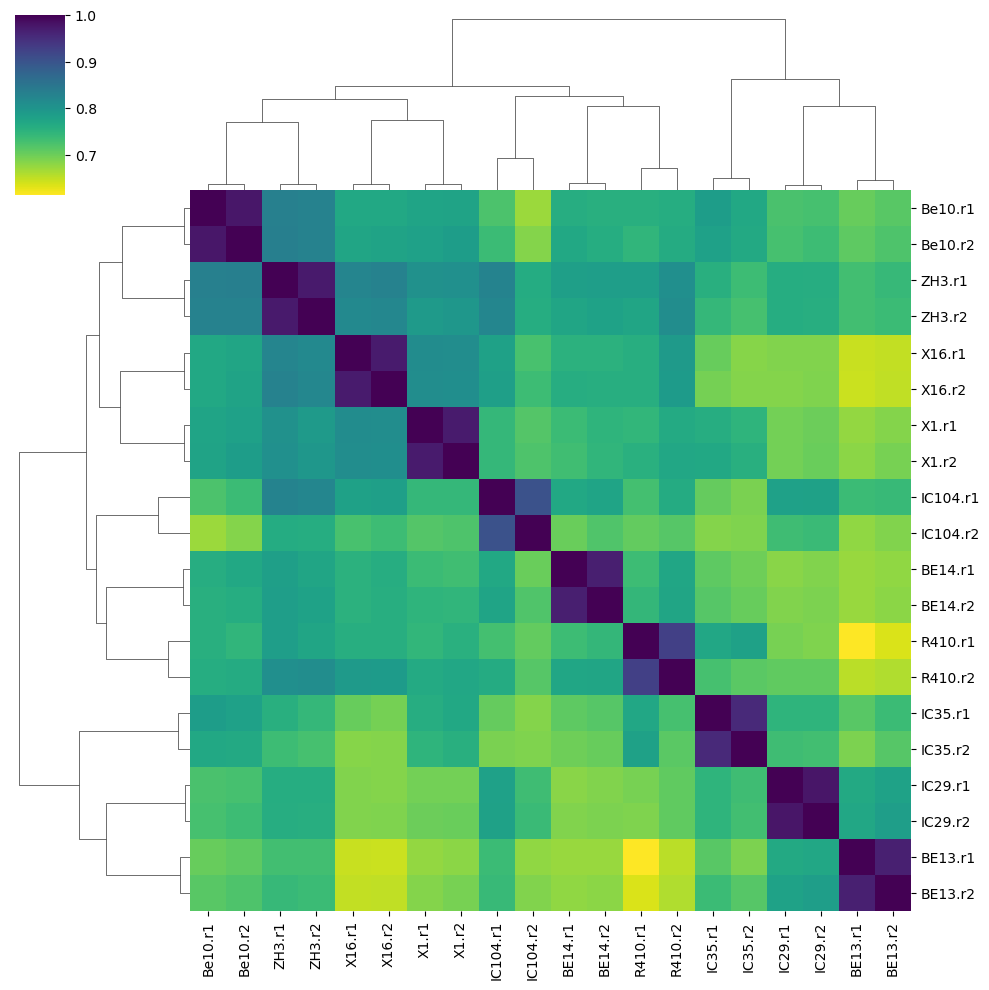

In [66]:
sns.clustermap(C, method='ward', cmap='viridis_r')

## Initial impression

we have overall well correlated samples, indicating a high degree of experimental consistency. Some of the replicates however have somewhat lower correlations (IC104 for example) and this might be a systematic length biases (seen that before). If so, we can attempt to mitigate this issue.

In [67]:
length_lkup = dfel.to_dict()['length']
id_from_gene = tpm_gene_id.to_dict()

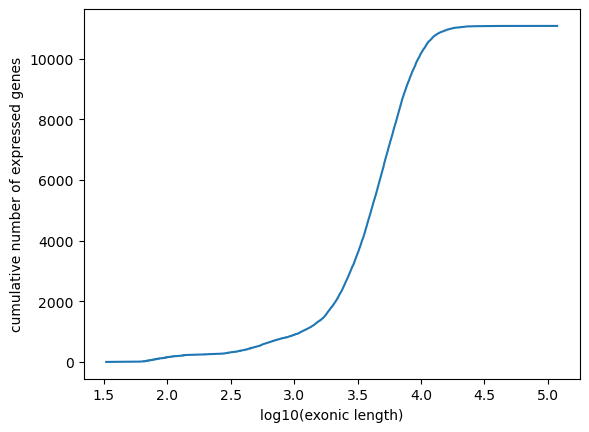

In [68]:
mat = dfl.copy() #tpm.set_index('gene').loc[expression_mask].copy()
lengths = np.array([length_lkup.get(gene, np.nan) for gene in mat.index])

x = np.log10(lengths)
xs = x.copy()
xs.sort()
fig, ax = plt.subplots()
ax.set_xlabel("log10(exonic length)")
ax.set_ylabel("cumulative number of expressed genes")
plt.plot(xs, np.arange(len(lengths)))



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


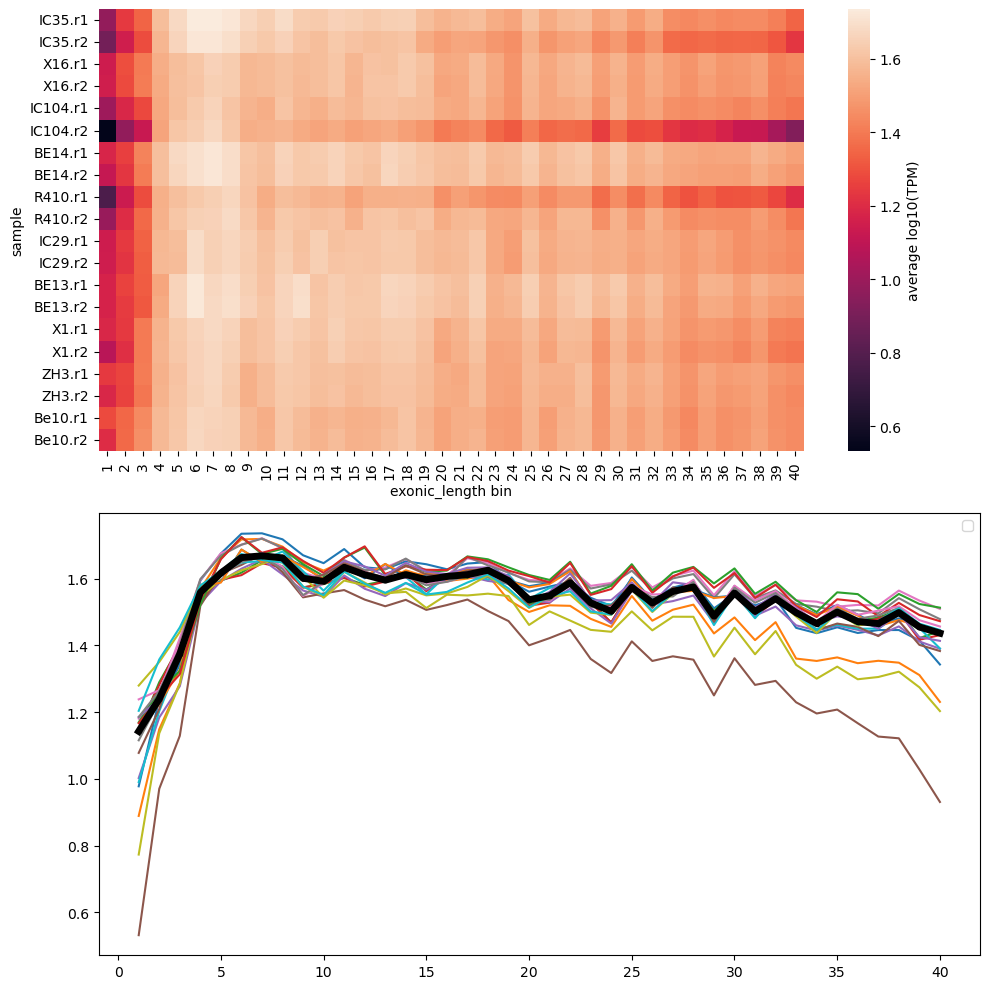

In [69]:

bins = xs[np.linspace(0, len(xs)-1, 41, dtype=int)]
bins[-1] += 1
bin_i = np.digitize(x, bins)
bin_n = sorted(set(bin_i))

data = {}
for n in bin_n:
    mask = bin_i == n
    data[n] = mat.loc[mask].mean(axis=0)
    #print(n, mask.sum()) #), data[n])

tpml = pd.DataFrame(data)
fig, (ax, ax2) = plt.subplots(2, figsize=(10,10))
sns.heatmap(tpml, ax=ax, cbar_kws={'label': "average log10(TPM)"}, yticklabels=True)
ax.set_xlabel("exonic_length bin")
ax.set_ylabel("sample")

ax2.plot(tpml.T)
ax2.legend()
bins = np.array(bins)
ld_mean = tpml.median(axis=0).T
ax2.plot(ld_mean, '.-k', lw=5)
fig.tight_layout()

# correction offsets





Text(50.722222222222214, 0.5, 'sample')

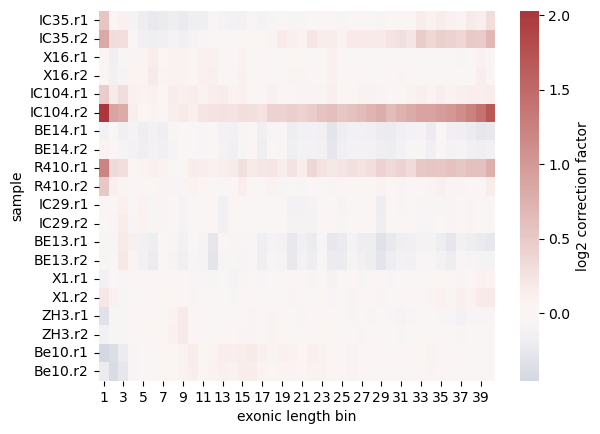

In [70]:
correction_factors = np.log2(10**(ld_mean - tpml))
fig, ax = plt.subplots()
sns.heatmap(correction_factors, cmap='vlag', center=0, ax=ax, cbar_kws={'label': "log2 correction factor"})
ax.set_xlabel("exonic length bin")
ax.set_ylabel("sample")

-0.45511241595289137 2.028086316039755


array([0.85231836, 1.56449272])

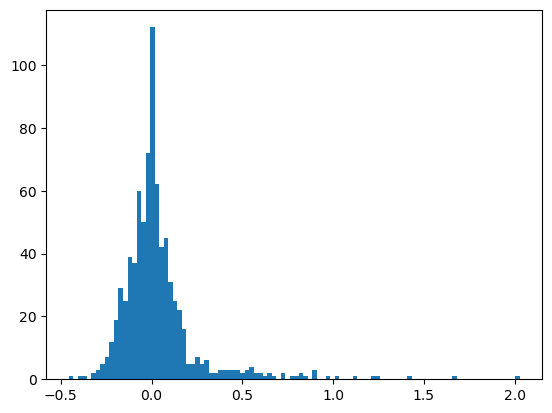

In [71]:
corrections = correction_factors.values.ravel()
print(corrections.min(), corrections.max())
_ = plt.hist(corrections, bins=100)
2**np.percentile(corrections, (2.5, 97.5))

In [72]:
corrections.shape

(800,)

In [73]:
ofs = (ld_mean - tpml).T
dfl_corr = dfl.copy()
le_len = np.log10([length_lkup[gene] for gene in dfl_corr.index])
lbin = np.digitize(le_len, bins)
shift = ofs.loc[lbin]
shift.index = dfl_corr.index
shift
dfl_corr += shift
dfl_corr


,IC35.r1,IC35.r2,X16.r1,X16.r2,IC104.r1,IC104.r2,BE14.r1,BE14.r2,R410.r1,R410.r2,IC29.r1,IC29.r2,BE13.r1,BE13.r2,X1.r1,X1.r2,ZH3.r1,ZH3.r2,Be10.r1,Be10.r2
gene,,,,,,,,,,,,,,,,,,,,
WASH7P,1.058806,0.913694,0.969307,1.067313,0.991443,0.914825,1.075615,1.088012,0.810921,0.833060,1.184758,1.154286,1.132635,1.240128,1.100157,1.021374,1.195466,1.254306,1.046273,1.032045
MTND1P23,1.049956,1.028433,0.943186,0.980609,1.190533,1.587153,0.598512,1.008957,0.614894,0.619440,0.872526,0.973314,0.723995,1.090275,1.203646,1.307545,1.004807,0.845550,0.803526,0.580988
MTND2P28,2.464072,2.579617,2.598930,2.562813,2.783234,2.692216,2.606502,2.583255,2.311481,2.302107,2.557788,2.569222,2.882787,2.905123,2.593811,2.663727,2.494282,2.558282,2.490817,2.440299
MTCO1P12,1.708902,1.742334,1.549557,1.487362,1.886973,1.746123,1.883362,1.848255,1.609993,1.676415,1.827996,1.867552,1.889566,1.835639,1.501155,1.406619,1.571981,1.583243,1.794603,1.734759
MTATP6P1,3.559824,3.622856,3.452138,3.409835,3.884267,4.002348,3.504932,3.519144,3.506064,3.531776,3.679331,3.717476,3.737780,3.773774,3.478859,3.496039,3.510169,3.560687,3.464589,3.438392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MT-ND6,4.086738,4.116881,4.130749,4.077709,4.308633,4.675948,4.198212,4.198900,3.933418,3.973644,4.162608,4.194927,4.092849,4.127534,4.212251,4.256714,4.083757,4.121340,3.994175,3.949045
MT-TE,2.829078,2.980154,2.813609,2.720190,3.019663,3.892785,3.020561,3.102986,2.596447,2.539556,2.815181,2.731719,2.785265,2.687789,3.300954,3.302492,2.659153,2.701057,2.924420,2.734280
MT-CYB,4.135021,4.163860,4.265040,4.248747,4.605625,4.480661,4.371265,4.392353,4.170739,4.314216,4.387211,4.409712,4.539764,4.551082,4.247257,4.266395,4.339513,4.390414,4.310301,4.318830


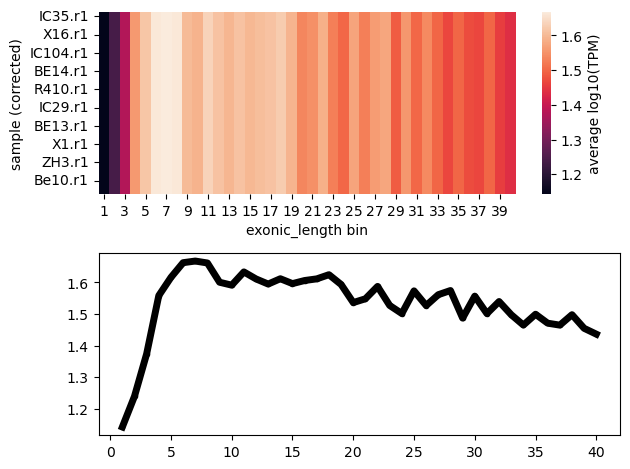

In [74]:

data = {}
for n in bin_n:
    mask = bin_i == n
    data[n] = dfl_corr.loc[mask].mean(axis=0)
    #print(n, mask.sum()) #), data[n])

tpml = pd.DataFrame(data)
fig, (ax, ax2) = plt.subplots(2)
sns.heatmap(tpml, ax=ax, cbar_kws={'label': "average log10(TPM)"})
ax.set_xlabel("exonic_length bin")
ax.set_ylabel("sample (corrected)")

ax2.plot(tpml.T)
bins = np.array(bins)
ld_mean = tpml.mean(axis=0).T
ax2.plot(ld_mean, '.-k', lw=5)
fig.tight_layout()

# correction offsets


In [75]:
dfl = dfl_corr
tpm_corr = 10**(dfl) - 0.01
tpm_corr

,IC35.r1,IC35.r2,X16.r1,X16.r2,IC104.r1,IC104.r2,BE14.r1,BE14.r2,R410.r1,R410.r2,IC29.r1,IC29.r2,BE13.r1,BE13.r2,X1.r1,X1.r2,ZH3.r1,ZH3.r2,Be10.r1,Be10.r2
gene,,,,,,,,,,,,,,,,,,,,
WASH7P,11.440009,8.187747,9.307656,11.666499,9.794901,8.209119,11.891871,12.236510,6.460249,6.798638,15.292341,14.255480,13.561727,17.373127,12.583802,10.494465,15.674348,17.949967,11.114316,10.755765
MTND1P23,11.209052,10.666611,8.763757,9.553320,15.497172,38.640294,3.957458,10.198385,4.109972,4.153322,7.446345,9.394024,5.286578,12.300494,15.972540,20.292276,10.101301,6.997292,6.351003,3.800550
MTND2P28,291.109695,379.844155,397.117574,365.427612,607.053174,492.274649,404.102584,383.039181,204.861063,200.486658,361.223509,370.860671,763.451633,803.744276,392.464504,461.018175,312.081700,361.634455,309.601467,275.602694
MTCO1P12,51.146666,55.240247,35.435141,30.705814,77.075570,55.724393,76.437284,70.500762,40.727406,47.459511,67.287028,73.704352,77.537223,68.481808,31.697025,25.494614,37.313394,38.293938,62.306437,54.284899
MTATP6P1,3629.302610,4196.190319,2832.284734,2569.409234,7660.668276,10054.191793,3198.386889,3304.779336,3206.733122,3402.316419,4778.924753,5217.654740,5467.380329,5939.816205,3012.017547,3133.557251,3237.187293,3636.522234,2914.657230,2744.039133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MT-ND6,12210.629511,13088.236781,13512.914378,11959.377553,20353.210339,47418.549059,15783.809352,15808.825130,8578.621534,9411.169496,14541.441435,15664.858492,12383.638544,13413.247078,16302.362807,18059.843439,12127.082628,13223.308007,9866.753136,8892.926150
MT-TE,674.638541,955.320751,651.032324,525.027366,1046.306168,7812.401358,1048.472796,1267.600466,394.853677,346.372523,653.393044,539.151508,609.898907,487.281593,1999.641348,2006.733941,456.188049,502.398771,840.263138,542.339872
MT-CYB,13646.476361,14583.425596,18409.398135,17731.537441,40329.700233,30245.525466,23510.664991,24680.442964,14816.276760,20616.536282,24389.943568,25686.887254,34654.801375,35569.833277,17670.836670,18466.941730,21853.112156,24570.499209,20431.545142,20836.720617


In [76]:
tpm_corr.sum(axis=0)

IC35.r1     1.285424e+06
IC35.r2     1.445286e+06
X16.r1      1.332070e+06
X16.r2      1.309642e+06
IC104.r1    1.694575e+06
IC104.r2    2.161922e+06
BE14.r1     1.255718e+06
BE14.r2     1.284499e+06
R410.r1     1.461221e+06
R410.r2     1.311416e+06
IC29.r1     1.367341e+06
IC29.r2     1.401902e+06
BE13.r1     1.384988e+06
BE13.r2     1.422465e+06
X1.r1       1.342751e+06
X1.r2       1.400194e+06
ZH3.r1      1.298956e+06
ZH3.r2      1.339167e+06
Be10.r1     1.357007e+06
Be10.r2     1.333802e+06
dtype: float64

In [77]:
tpm.sum(axis=0)

IC35.r1     1.320305e+06
IC35.r2     1.324402e+06
X16.r1      1.313586e+06
X16.r2      1.282718e+06
IC104.r1    1.534289e+06
IC104.r2    1.482755e+06
BE14.r1     1.378351e+06
BE14.r2     1.379434e+06
R410.r1     1.225767e+06
R410.r2     1.276330e+06
IC29.r1     1.368868e+06
IC29.r2     1.393833e+06
BE13.r1     1.460700e+06
BE13.r2     1.484134e+06
X1.r1       1.374475e+06
X1.r2       1.392297e+06
ZH3.r1      1.314924e+06
ZH3.r2      1.340282e+06
Be10.r1     1.370484e+06
Be10.r2     1.351282e+06
dtype: float64

## Normalization of counts!

In [78]:
# 100 counts in at least 3 samples (both replicates)
expression_mask = (counts >= 100).sum(axis=1) >= 6
print(expression_mask.sum())
# yields ~ 11,000 genes
cexpr = counts.loc[expression_mask]


11746


In [79]:
cexpr

,IC35.r1,IC35.r2,X16.r1,X16.r2,IC104.r1,IC104.r2,BE14.r1,BE14.r2,R410.r1,R410.r2,IC29.r1,IC29.r2,BE13.r1,BE13.r2,X1.r1,X1.r2,ZH3.r1,ZH3.r2,Be10.r1,Be10.r2
gene,,,,,,,,,,,,,,,,,,,,
WASH7P,100,83,82,94,86,69,128,138,63,67,142,126,96,151,103,84,148,148,96,105
MTND2P28,1190,1765,1751,1478,2553,1879,2113,2116,1038,1021,1823,1799,2468,3275,1586,1879,1463,1514,1446,1462
MTCO1P12,326,412,227,185,488,344,622,593,298,359,458,474,446,477,194,153,255,233,411,412
MTATP6P1,8273,10156,8915,7667,18123,15605,11167,11674,8842,10960,14089,14185,11161,14436,8391,8683,10627,10323,9855,10883
LINC01128,382,408,601,555,580,279,555,533,983,1166,750,720,564,627,420,411,1575,1318,1000,1025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MT-ND5,91577,95794,133573,108052,169484,54471,156346,158646,67290,84522,146938,144067,90930,119500,111857,115813,118059,110061,113142,116124
MT-ND6,23061,24249,34813,28265,40781,53701,39398,39379,17686,22390,35828,35302,23139,29240,33130,33914,30496,29335,28493,29702
MT-TE,115,160,196,151,227,530,363,397,58,83,210,166,151,146,591,458,177,153,339,209


In [80]:
dfl = np.log10(cexpr + 1)


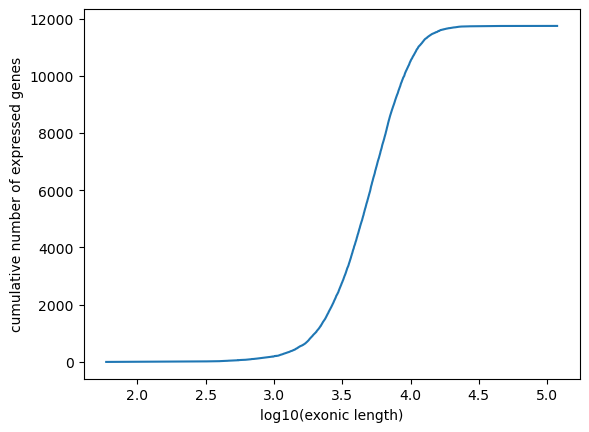

In [81]:
mat = dfl.copy() #tpm.set_index('gene').loc[expression_mask].copy()
lengths = np.array([length_lkup.get(gene, np.nan) for gene in mat.index])

x = np.log10(lengths)
xs = x.copy()
xs.sort()
fig, ax = plt.subplots()
ax.set_xlabel("log10(exonic length)")
ax.set_ylabel("cumulative number of expressed genes")
plt.plot(xs, np.arange(len(lengths)))



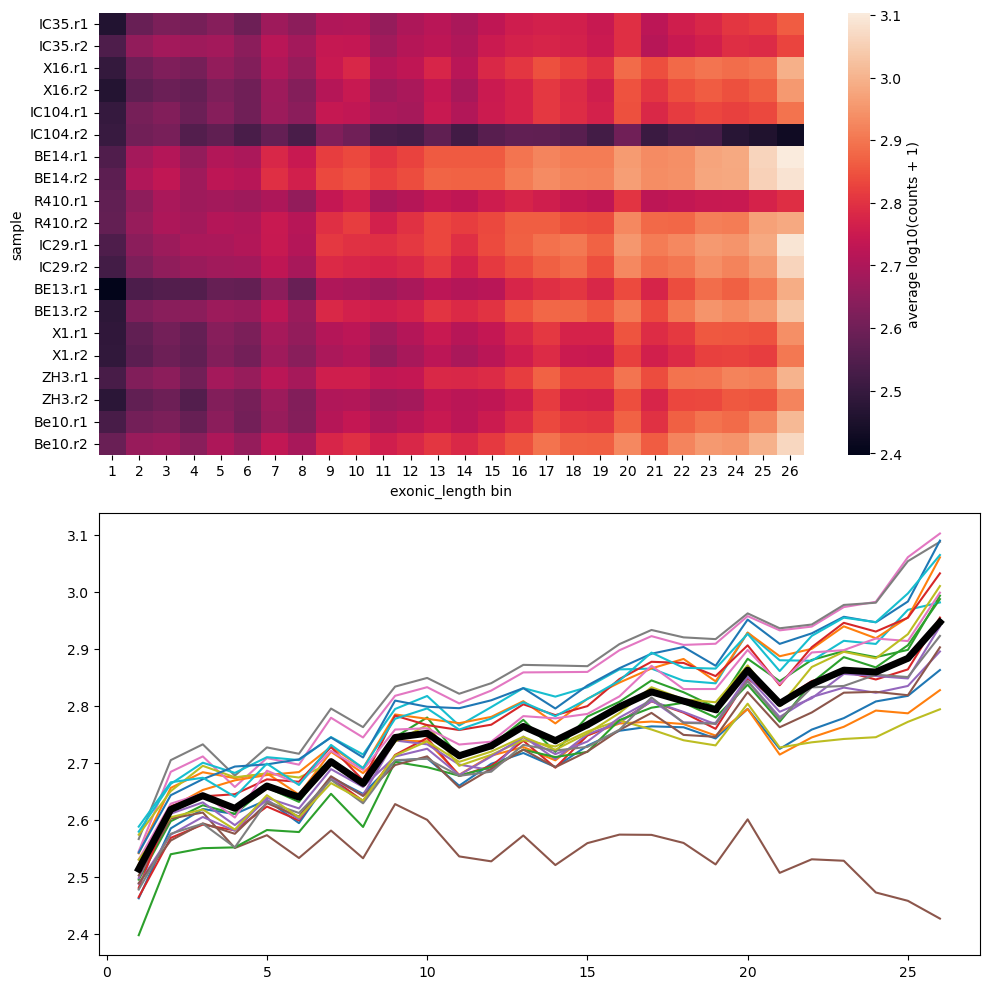

In [82]:

nbins = 27
bins = xs[np.linspace(0, len(xs)-1, nbins, dtype=int)]
bins[-1] += 1
bin_i = np.digitize(x, bins)
bin_n = sorted(set(bin_i))

data = {}
for n in bin_n:
    mask = bin_i == n
    data[n] = mat.loc[mask].mean(axis=0)
    #print(n, mask.sum()) #), data[n])

cl = pd.DataFrame(data)
fig, (ax, ax2) = plt.subplots(2, figsize=(10,10))
sns.heatmap(cl, ax=ax, cbar_kws={'label': "average log10(counts + 1)"}, yticklabels=True)
ax.set_xlabel("exonic_length bin")
ax.set_ylabel("sample")

ax2.plot(cl.T)
bins = np.array(bins)
ld_mean = cl.mean(axis=0).T
ax2.plot(ld_mean, '.-k', lw=5)
fig.tight_layout()

# correction offsets





Text(50.722222222222214, 0.5, 'sample')

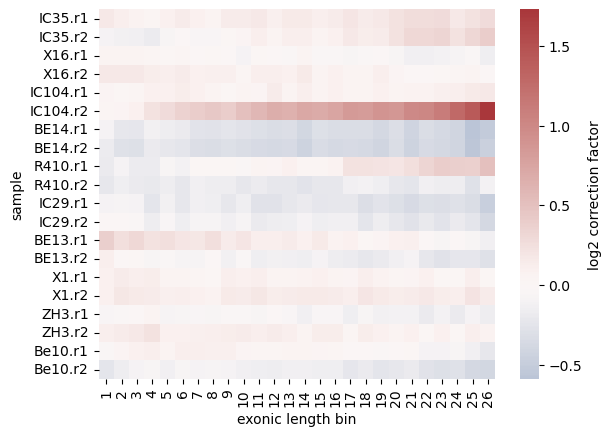

In [83]:
fig, ax = plt.subplots()
ofs = ld_mean - cl
sns.heatmap(np.log2(10**ofs), cmap='vlag', center=0, ax=ax, cbar_kws={'label': "log2 correction factor"})
ax.set_xlabel("exonic length bin")
ax.set_ylabel("sample")

In [84]:
ofs

,1,2,3,4,5,6,7,8,9,10,...,17,18,19,20,21,22,23,24,25,26
IC35.r1,0.051353,0.033159,0.023328,0.010027,0.024528,0.045606,0.027866,0.018456,0.041098,0.043905,...,0.060532,0.045944,0.050456,0.067917,0.079701,0.079656,0.084270,0.051642,0.065892,0.083934
IC35.r2,-0.027725,-0.037896,-0.041207,-0.052974,-0.022328,-0.004494,-0.017201,-0.018014,0.005537,0.014249,...,0.052068,0.040297,0.045367,0.068258,0.089719,0.093398,0.099469,0.067622,0.096537,0.119241
X16.r1,0.018615,0.020614,0.016780,0.009689,0.002631,0.008384,-0.002363,-0.000266,-0.000591,-0.027643,...,-0.020137,-0.015569,-0.004180,-0.019968,-0.039107,-0.042624,-0.033464,-0.026147,-0.014844,-0.046637
X16.r2,0.049369,0.049824,0.050716,0.038665,0.036086,0.040819,0.028508,0.030818,0.030566,0.008298,...,0.016637,0.020260,0.033534,0.015016,-0.003182,-0.005509,0.001991,0.013109,0.019432,-0.008200
IC104.r1,0.015821,0.007330,0.011757,0.029513,0.024599,0.038571,0.029556,0.020417,0.005306,0.019447,...,0.016186,0.018987,0.025533,0.018751,0.023788,0.022512,0.030652,0.036398,0.048507,0.051347
IC104.r2,0.011252,0.015973,0.029580,0.069637,0.086416,0.106835,0.121087,0.131444,0.116992,0.152020,...,0.251043,0.248967,0.271579,0.261962,0.297354,0.307354,0.334642,0.387002,0.425713,0.520316
BE14.r1,-0.031059,-0.066142,-0.068935,-0.037500,-0.049028,-0.057009,-0.076925,-0.080610,-0.073159,-0.080881,...,-0.097856,-0.098685,-0.115828,-0.094831,-0.128353,-0.101195,-0.110663,-0.123224,-0.177561,-0.155726
BE14.r2,-0.052658,-0.086632,-0.090134,-0.057379,-0.067749,-0.076128,-0.093125,-0.098735,-0.089293,-0.097121,...,-0.108678,-0.111910,-0.123956,-0.099633,-0.131996,-0.104797,-0.114451,-0.121711,-0.170528,-0.141157
R410.r1,-0.060279,-0.032285,-0.052434,-0.054453,-0.021937,-0.034430,0.002509,0.005422,0.007488,-0.014444,...,0.066075,0.068707,0.062631,0.058902,0.077254,0.101979,0.120839,0.114412,0.111532,0.152862
R410.r2,-0.065614,-0.044957,-0.057900,-0.062189,-0.050580,-0.065080,-0.043009,-0.050769,-0.050012,-0.065428,...,-0.040866,-0.035794,-0.046344,-0.065877,-0.075863,-0.041184,-0.051483,-0.049325,-0.085160,-0.034705


In [85]:

#from scipy.interpolate import splrep
#x = np.arange(len(ofs))
#tck_s = splrep(x, ofs, s=len(x))


In [86]:
ofs = (ld_mean - cl).T
dfl_corr = dfl.copy()
le_len = np.log10([length_lkup[gene] for gene in dfl_corr.index])
lbin = np.digitize(le_len, bins)
shift = ofs.loc[lbin]
shift.index = dfl_corr.index
shift
dfl_corr += shift
dfl_corr


,IC35.r1,IC35.r2,X16.r1,X16.r2,IC104.r1,IC104.r2,BE14.r1,BE14.r2,R410.r1,R410.r2,IC29.r1,IC29.r2,BE13.r1,BE13.r2,X1.r1,X1.r2,ZH3.r1,ZH3.r2,Be10.r1,Be10.r2
gene,,,,,,,,,,,,,,,,,,,,
WASH7P,2.027649,1.883073,1.935858,2.028439,1.951276,1.874679,2.041655,2.052880,1.753746,1.774609,2.126366,2.093740,2.078920,2.183040,2.054370,1.977985,2.169450,2.222367,2.011041,1.993826
MTND2P28,3.127264,3.219266,3.262149,3.219338,3.423042,3.285409,3.294046,3.273063,2.956337,2.943837,3.232188,3.246797,3.508652,3.548367,3.226450,3.298962,3.148804,3.216400,3.144049,3.090820
MTCO1P12,2.547707,2.578054,2.378548,2.319337,2.696638,2.553792,2.728346,2.687154,2.443387,2.511346,2.636785,2.673141,2.728843,2.673505,2.334290,2.241993,2.398032,2.411803,2.628514,2.568206
MTATP6P1,3.969068,3.979040,3.968785,3.934051,4.274075,4.204543,4.016917,4.014599,3.886321,3.974236,4.120074,4.143384,4.163873,4.192501,3.949739,3.963524,4.009715,4.049835,3.977281,3.962365
LINC01128,2.662855,2.705121,2.736973,2.739565,2.786688,2.754512,2.643880,2.622744,3.094974,3.025886,2.786351,2.795850,2.749600,2.732966,2.649066,2.664513,3.141864,3.125858,2.970200,2.926288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MT-ND5,4.994950,4.943447,5.146336,5.083461,5.236461,4.752146,5.127948,5.113800,4.795672,4.882018,5.142109,5.155014,5.037247,5.071448,5.092923,5.118233,5.061895,5.084225,5.067245,5.017182
MT-ND6,4.414250,4.356987,4.560368,4.500634,4.626289,4.741242,4.564427,4.542617,4.187376,4.284459,4.525398,4.539336,4.480495,4.499016,4.546108,4.555196,4.467520,4.503388,4.438334,4.398376
MT-TE,2.115811,2.179101,2.313081,2.231213,2.373756,2.736346,2.530043,2.547225,1.710573,1.858665,2.295445,2.214241,2.297975,2.200341,2.798195,2.686617,2.233683,2.223508,2.515059,2.247795


In [87]:
counts_corr = (10**dfl_corr - 1)


In [88]:
log2_corr = np.log2((np.clip(counts_corr, 0, np.inf)+1)/(cexpr+1)).values.ravel()

array([0.76207669, 1.61345277])

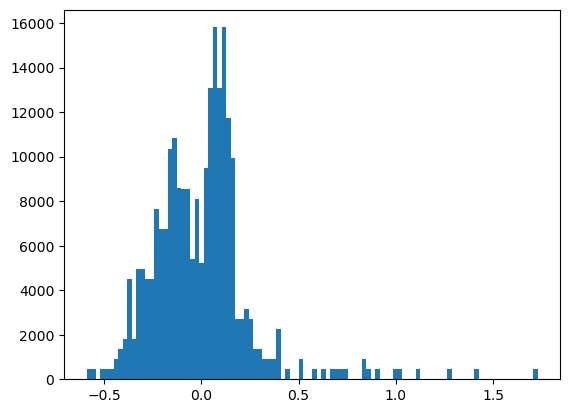

In [89]:
_ = plt.hist(log2_corr, bins=100)
2**np.percentile(log2_corr, (2.5, 97.5))

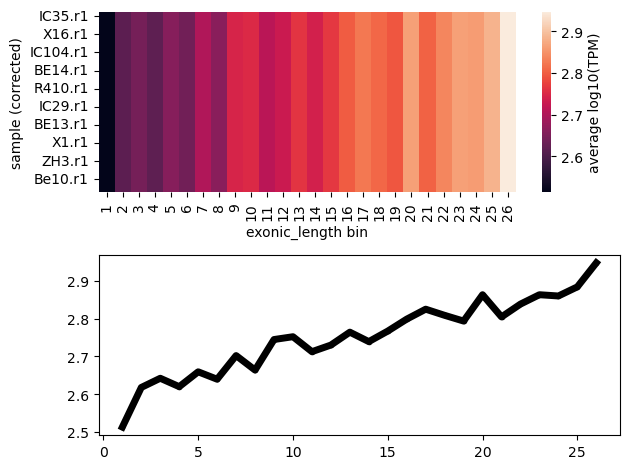

In [90]:

data = {}
for n in bin_n:
    mask = bin_i == n
    data[n] = dfl_corr.loc[mask].mean(axis=0)
    #print(n, mask.sum()) #), data[n])

cl = pd.DataFrame(data)
fig, (ax, ax2) = plt.subplots(2)
sns.heatmap(cl, ax=ax, cbar_kws={'label': "average log10(TPM)"})
ax.set_xlabel("exonic_length bin")
ax.set_ylabel("sample (corrected)")

ax2.plot(cl.T)
bins = np.array(bins)
ld_mean = cl.mean(axis=0).T
ax2.plot(ld_mean, '.-k', lw=5)
fig.tight_layout()

# correction offsets


In [91]:
np.array(10**bins, dtype=int)

array([     59,    1437,    1911,    2258,    2548,    2830,    3111,
          3379,    3634,    3881,    4145,    4420,    4687,    4978,
          5267,    5582,    5937,    6293,    6675,    7064,    7583,
          8162,    8833,    9738,   10886,   12813, 1183270])

In [92]:
dfl = dfl_corr
tpm_corr = 10**(dfl) - 0.01
tpm_corr

,IC35.r1,IC35.r2,X16.r1,X16.r2,IC104.r1,IC104.r2,BE14.r1,BE14.r2,R410.r1,R410.r2,IC29.r1,IC29.r2,BE13.r1,BE13.r2,X1.r1,X1.r2,ZH3.r1,ZH3.r2,Be10.r1,Be10.r2
gene,,,,,,,,,,,,,,,,,,,,
WASH7P,106.563490,76.386363,86.259731,106.757523,89.377368,74.923935,110.056482,112.938469,56.711334,59.502656,133.762256,124.080835,119.917918,152.409334,113.326560,95.047093,147.713691,166.855806,102.564762,98.578548
MTND2P28,1340.482568,1656.772566,1828.716154,1657.047204,2648.743636,1929.332761,1968.086778,1875.254427,904.340977,878.681766,1706.810368,1765.201149,3225.901525,3534.811382,1684.409190,1990.490864,1408.643075,1645.875502,1393.303376,1232.585011
MTCO1P12,352.934568,378.479495,239.072877,208.601032,497.312852,357.915011,534.980866,486.569902,277.568988,324.587907,433.286281,471.119744,535.593033,471.514905,215.908793,174.569344,250.043225,258.099031,425.112826,369.993607
MTATP6P1,9312.530312,9528.835144,9306.452549,8591.142561,18796.392077,16015.587407,10397.201360,10341.847434,7696.982965,9424.002177,13184.803037,13911.815199,14583.880012,15577.589599,8907.139240,9194.409947,10226.195518,11215.912064,9490.312482,9169.890274
LINC01128,460.092941,507.121774,545.713807,548.981334,611.900899,568.203789,440.422698,419.501553,1244.430458,1061.408032,611.425648,624.947233,561.814087,540.702003,445.714237,461.852412,1386.310757,1336.148980,933.674351,843.884418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MT-ND5,98843.897246,87790.307590,140066.903067,121188.419224,172369.649801,56512.718130,134260.370193,129956.962626,62470.115967,76211.070269,138710.495935,142894.137362,108955.066970,117882.202675,123857.653042,131290.458193,115317.504832,121401.682920,116746.766558,104035.507861
MT-ND6,25956.698323,22750.260231,36338.615749,31668.941262,42295.005973,55111.460713,36679.765284,34883.274433,15394.846335,19251.249617,33527.219689,34620.683994,30233.927903,31551.184146,35164.761387,35908.413825,29344.042474,31870.417127,27436.805017,25025.123024
MT-TE,130.550149,151.033031,205.617313,170.289320,236.448821,544.926705,338.867591,352.543256,51.343905,72.211241,197.434681,163.762368,198.588036,158.603780,628.330366,485.968668,171.260661,167.294533,327.375313,176.917514


In [93]:
tpm_corr.sum(axis=0)

IC35.r1     1.794146e+07
IC35.r2     1.983689e+07
X16.r1      1.974092e+07
X16.r2      1.968987e+07
IC104.r1    2.173517e+07
IC104.r2    2.429491e+07
BE14.r1     1.752810e+07
BE14.r2     1.781677e+07
R410.r1     2.341285e+07
R410.r2     1.967386e+07
IC29.r1     1.819973e+07
IC29.r2     1.825773e+07
BE13.r1     1.766049e+07
BE13.r2     1.801544e+07
X1.r1       1.866164e+07
X1.r2       1.918972e+07
ZH3.r1      1.991872e+07
ZH3.r2      2.010236e+07
Be10.r1     1.994913e+07
Be10.r2     1.964628e+07
dtype: float64

In [94]:
tpm.sum(axis=0)

IC35.r1     1.320305e+06
IC35.r2     1.324402e+06
X16.r1      1.313586e+06
X16.r2      1.282718e+06
IC104.r1    1.534289e+06
IC104.r2    1.482755e+06
BE14.r1     1.378351e+06
BE14.r2     1.379434e+06
R410.r1     1.225767e+06
R410.r2     1.276330e+06
IC29.r1     1.368868e+06
IC29.r2     1.393833e+06
BE13.r1     1.460700e+06
BE13.r2     1.484134e+06
X1.r1       1.374475e+06
X1.r2       1.392297e+06
ZH3.r1      1.314924e+06
ZH3.r2      1.340282e+06
Be10.r1     1.370484e+06
Be10.r2     1.351282e+06
dtype: float64

In [95]:
tpm_corr = tpm_corr.divide(tpm_corr.sum(axis=0)/1E6, axis=1)
tpm_corr.sum(axis=0)

IC35.r1     1000000.0
IC35.r2     1000000.0
X16.r1      1000000.0
X16.r2      1000000.0
IC104.r1    1000000.0
IC104.r2    1000000.0
BE14.r1     1000000.0
BE14.r2     1000000.0
R410.r1     1000000.0
R410.r2     1000000.0
IC29.r1     1000000.0
IC29.r2     1000000.0
BE13.r1     1000000.0
BE13.r2     1000000.0
X1.r1       1000000.0
X1.r2       1000000.0
ZH3.r1      1000000.0
ZH3.r2      1000000.0
Be10.r1     1000000.0
Be10.r2     1000000.0
dtype: float64

### TPM Normalization failure?

I just took the tpm values from the table at face value, never checked if they added up to one million. Turns out they did not! Strange... let-s at least make sure that the corrected counts are `correct`.

In [96]:
tpm_corr.to_csv("../data/length_corrected.tpm.csv.gz", sep='\t')
counts_corr.to_csv("../data/length_corrected.counts.csv.gz", sep='\t')

In [97]:
tpm_corr = pd.read_csv("../data/length_corrected.tpm.csv.gz", sep='\t').set_index('gene')

In [98]:
dfl_corr = np.log10(tpm_corr + 0.01)

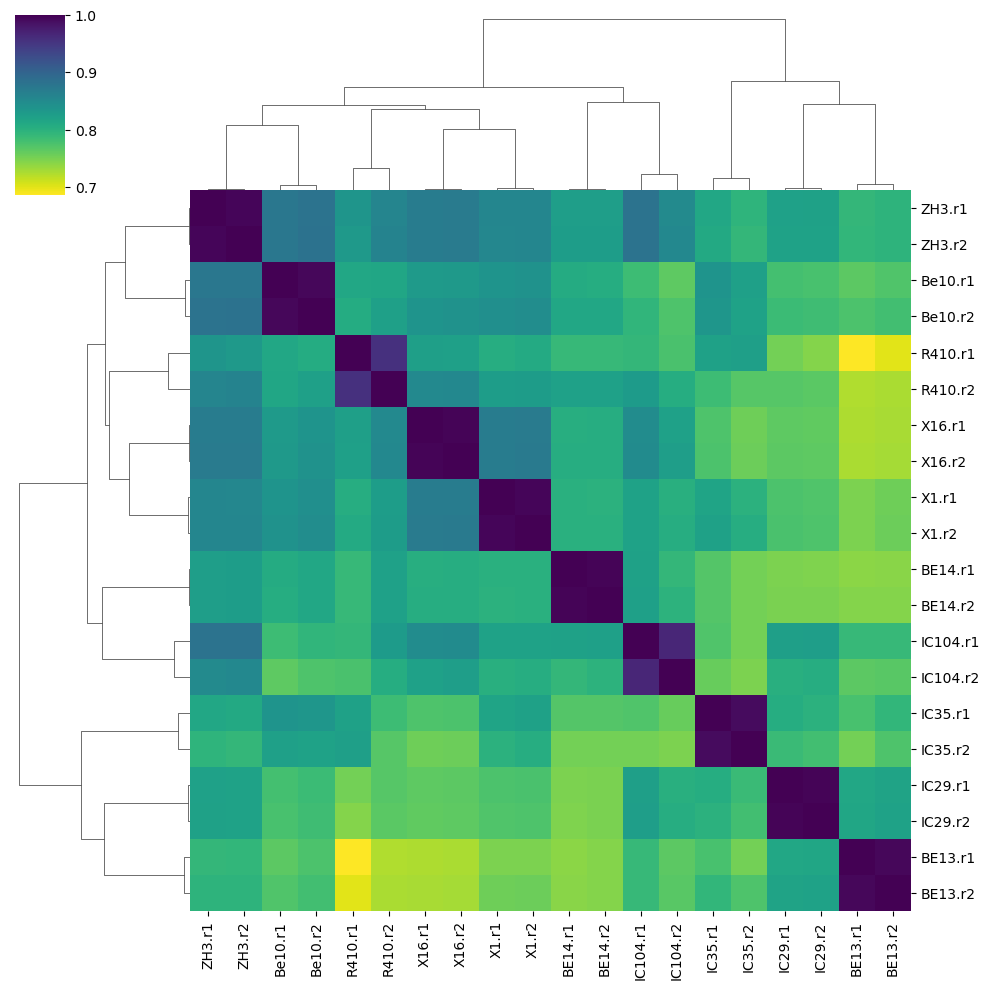

In [99]:
C = dfl_corr.corr()
sns.clustermap(C, method='ward', cmap='viridis_r')